# Packages

In [21]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
import torch
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

In [22]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.15  Python-3.9.13 torch-2.3.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Setup complete  (16 CPUs, 15.9 GB RAM, 165.0/192.0 GB disk)


# Data Preprocessing

In [23]:
directory = "data/" # directory dataset
image_directory = directory + "/images" # Don't forget to look at the name of the folder where his photos are stored. As in the picture above, in the name images we type /images.
annotation_directory = directory + "/annotations" # Don't forget to look at the name of the annotate folder. As in the picture above, in the name of annotations, we type /annotations.
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

In [24]:
# This class_id is also important. We have to declare class for labels by id. Let's type it in here and go down.
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')
        
        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

filename         label  class_id  width  height  \
0  maksssksksss0.png  without_mask         2    512     366   
1  maksssksksss0.png     with_mask         0    512     366   
2  maksssksksss0.png  without_mask         2    512     366   
3  maksssksksss1.png     with_mask         0    400     156   
4  maksssksksss1.png     with_mask         0    400     156   

                 bboxes  
0   [79, 105, 109, 142]  
1  [185, 100, 226, 144]  
2   [325, 90, 360, 141]  
3    [321, 34, 354, 69]  
4    [224, 38, 261, 73]

In [25]:
df_data.isna().sum() # Check the null value

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [26]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [27]:
df_data.label.unique() # Class names of labels

array(['without_mask', 'with_mask', 'mask_weared_incorrect'], dtype=object)

In [28]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


# Visualize Data


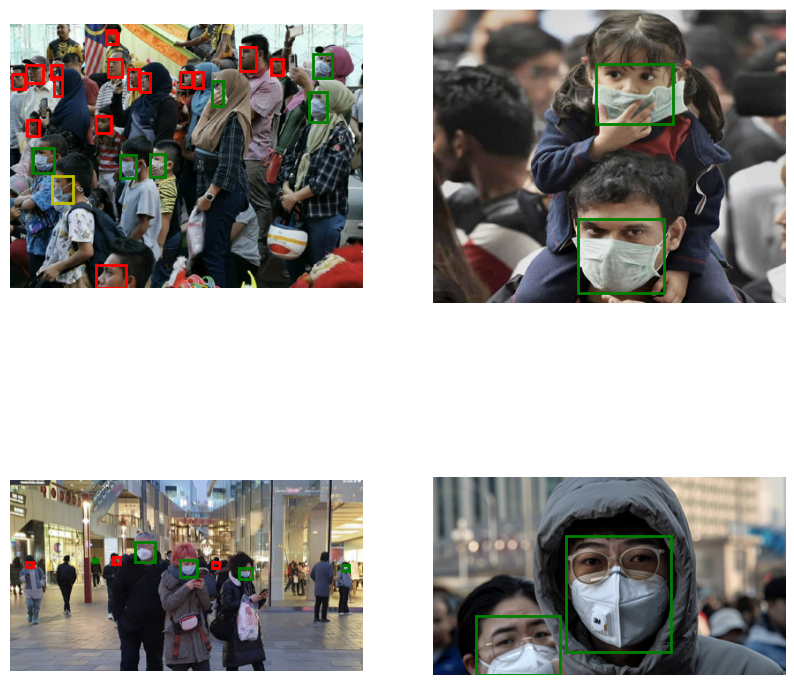

In [29]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]
        
        image = Image.open(image_directory + '/' + filename)
        
        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)
        
        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"
            
            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes
            
            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)
            
show_random_images_with_bbox(df_data)

In [30]:
# we need to convert our bbox format to yolo as the current one that we have is on pascal_voc
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array
    
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

# spliting the Data

In [32]:
train_path = "datasets/train"
valid_path = "datasets/valid"
test_path = "datasets/test"

os.mkdir("datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [33]:
random_state = 42 
 
train, test = train_test_split(df_data.filename.unique(), test_size=0.1, random_state=random_state)
train, valid = train_test_split(train, test_size=0.2, random_state=random_state)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")
                

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [34]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")
    
walk_through_dir(train_path)
walk_through_dir(valid_path)  
walk_through_dir(test_path) 

There are 0 directories and 613 images in 'datasets/train'.
There are 0 directories and 154 images in 'datasets/valid'.
There are 0 directories and 86 images in 'datasets/test'.


In [39]:
classes = list(df_data.label.unique())
class_count = len(classes)
train_config_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """                                     # Don't forget to convert the class in here to be the same as the one above that we set.

with open('train_config.yaml', 'w') as f:
    f.write(train_config_yaml)
    
%cat train_config.yaml

UsageError: Line magic function `%cat` not found.


In [42]:
model = YOLO("yolov8n.pt") # You can choose the yolo version here, it's up to you which one you want. Here i choose
model.train(data="train_config.yaml", epochs=100) # กำหนดได้ว่าให้ train กี่ครั้ง ตรง epochs=

Ultralytics YOLOv8.2.15  Python-3.9.13 torch-2.3.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=train_config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning C:\Users\legion 5 pro\Desktop\CV\datasets\train.cache... 613 images, 0 backgrounds, 0 corrupt: 100%|███
val: Scanning C:\Users\legion 5 pro\Desktop\CV\datasets\valid.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|█████

Plotting labels to runs\detect\train3\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.703      2.642      1.328         23        640: 100%|██████████| 39/39 [03:21<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711     0.0118      0.544      0.259      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G       1.32      1.445      1.083         92        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.956      0.199      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.276      1.282      1.062         54        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711       0.48      0.439      0.458      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G       1.23      1.142      1.041         29        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.488       0.47      0.506      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.203      1.054      1.039         37        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711       0.53      0.588      0.553      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.203     0.9732      1.024         20        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.523      0.499      0.567      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.178     0.9455      1.023         27        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.845      0.578      0.663      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.183      0.913      1.024         32        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.699      0.588      0.659      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.164     0.8709      1.013         34        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.681      0.694      0.704      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.182     0.8754      1.029        117        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.82      0.635      0.693      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.141     0.8002     0.9996         45        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.737      0.667      0.731       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.115     0.7676     0.9911         55        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.884       0.61      0.677      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.131     0.7886     0.9995         47        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.745      0.628      0.709      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.118     0.7672     0.9929         58        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.742      0.685      0.727      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G        1.1     0.7585     0.9892         79        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.79      0.542      0.683      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.119     0.7476     0.9887         28        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.616      0.614      0.619      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.116     0.7374     0.9957         27        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.772       0.62      0.722      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.105     0.7082     0.9854         56        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.806      0.618        0.7       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.094     0.7039     0.9809         28        640: 100%|██████████| 39/39 [03:20<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.748      0.708      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.067     0.6763     0.9794         34        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.707      0.783      0.755      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.089     0.6908     0.9818         45        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.757      0.722       0.76      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.073     0.6893       0.98         32        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.728      0.745      0.772      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.086     0.6869     0.9858         55        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.825      0.647      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.064     0.6581     0.9748         27        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.869      0.703      0.805      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.039     0.6424     0.9748         47        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711        0.9      0.659       0.75      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G       1.06     0.6506     0.9811         29        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.704       0.73      0.743      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.058     0.6266      0.967         40        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.883      0.656      0.751      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.089     0.6513     0.9773         84        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.832       0.69      0.776      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.062     0.6319     0.9758         33        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.775      0.683      0.701      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G       1.04     0.6213     0.9786         34        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.888      0.667      0.797      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.034     0.6114     0.9592         49        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.903      0.688      0.783      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.008     0.5884     0.9551         25        640: 100%|██████████| 39/39 [03:22<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.787       0.75       0.78      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.013     0.6085     0.9729         46        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.755      0.732      0.778      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.024     0.5933     0.9551         14        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.801      0.749      0.804      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.026     0.5955      0.957         77        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.882      0.736       0.81      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.9997     0.5827     0.9538         18        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.798      0.713      0.772      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9843     0.5741     0.9527         44        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.811      0.699      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.009     0.5828      0.955         37        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.886      0.747      0.833      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.9829     0.5675     0.9542         62        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.795      0.788      0.814      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.003     0.5764     0.9584         19        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.714      0.716      0.758      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.9836     0.5665     0.9523         81        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.844      0.816      0.856      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      0.978     0.5645      0.952         15        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.835      0.787      0.813      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9729     0.5487      0.938        100        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.838      0.761      0.787       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9595     0.5371     0.9405         58        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.911      0.739      0.835      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9712     0.5551     0.9467         39        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.828      0.722      0.804      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9684     0.5466     0.9452         19        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.829      0.709        0.8      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9377      0.519     0.9414         27        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.874      0.698      0.788      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9603     0.5351     0.9456         44        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.88      0.744      0.816      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9462     0.5289     0.9396         25        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.863      0.725      0.821      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9601     0.5276     0.9434         58        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.931      0.689      0.824      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9615     0.5426      0.949         28        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.846       0.71      0.808      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      0.965     0.5336      0.938         34        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.897      0.749       0.83      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9464     0.5164     0.9356         21        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.861       0.75      0.842      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.9299     0.5105     0.9328         48        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.812      0.797      0.829      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      0.947     0.5136     0.9277         22        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.893      0.739      0.836      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.9183     0.5004     0.9224         36        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.903      0.745      0.844      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9386     0.5099     0.9273        130        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.854        0.7       0.82      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.9166      0.499     0.9306         49        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.846      0.722      0.808      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.9164      0.495     0.9211         44        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.874       0.71      0.804      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.9106     0.4874     0.9241         19        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.833      0.755      0.816      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8832     0.4797     0.9111         53        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.82      0.784       0.84      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.9231     0.5012     0.9237         18        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.843      0.763       0.85      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8831     0.4774     0.9201         25        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.889      0.759      0.855      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      0.891     0.4867     0.9165         35        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.857      0.763      0.828      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8588     0.4674     0.9093         24        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.868      0.732      0.829      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8528     0.4681     0.9134         20        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.906      0.735      0.853      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8809     0.4789     0.9177         52        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.869      0.745      0.849      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8821     0.4789     0.9046         27        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.919      0.729      0.852        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8621     0.4651      0.909         45        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.874      0.764      0.847      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8789     0.4657     0.9129         40        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.795      0.777      0.826      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8687     0.4607     0.9088         22        640: 100%|██████████| 39/39 [03:20<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.804      0.764      0.827      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8688     0.4607     0.9148         61        640: 100%|██████████| 39/39 [03:24<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.901      0.757      0.851      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.8599     0.4519     0.9109         17        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.887      0.755      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      0.858     0.4609     0.9109         74        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.858       0.77      0.849      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.8381     0.4457     0.9083         58        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.871      0.758      0.827      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.8493      0.446     0.9028         40        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.826      0.765      0.813      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.8529     0.4523      0.902        262        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.851      0.745      0.822      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      0.877      0.464     0.8998         36        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.964      0.703      0.842      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.8347     0.4432     0.8997         38        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.935      0.737      0.855      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.8318     0.4287     0.8933         27        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.883      0.746      0.849      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.8156     0.4298     0.8982         20        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.906      0.737      0.838      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.8175      0.426     0.8914         30        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.895      0.721      0.849      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.8161     0.4291     0.8956         23        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.893      0.749      0.866      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.8014     0.4185     0.8913         26        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.936      0.742       0.85      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      0.815     0.4251     0.8943         28        640: 100%|██████████| 39/39 [03:29<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<0

                   all        154        711      0.907      0.759      0.845      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.8185     0.4195     0.8907         54        640: 100%|██████████| 39/39 [03:24<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.899      0.763      0.846      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7939     0.4135     0.8879         30        640: 100%|██████████| 39/39 [03:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.882      0.768      0.851      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.8068      0.415     0.8898         24        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.887      0.761      0.857      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7929     0.4157     0.8873         36        640: 100%|██████████| 39/39 [03:18<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.905      0.767      0.855      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7977     0.4151     0.8835         16        640: 100%|██████████| 39/39 [03:19<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.88      0.756      0.851       0.59


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.7935     0.3929     0.8798          8        640: 100%|██████████| 39/39 [03:15<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.868      0.729      0.834      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.763     0.3784     0.8684         15        640: 100%|██████████| 39/39 [03:13<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.871      0.748       0.84      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.7638     0.3768     0.8709         15        640: 100%|██████████| 39/39 [03:13<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711       0.87      0.756      0.843      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.7559     0.3722     0.8733         16        640: 100%|██████████| 39/39 [03:13<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.856      0.758      0.842      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G       0.76     0.3645     0.8663         23        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.853      0.775      0.846      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.7549     0.3671     0.8709         24        640: 100%|██████████| 39/39 [03:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.876      0.748      0.847      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.7456     0.3658     0.8695         22        640: 100%|██████████| 39/39 [03:14<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.855      0.756      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.7409     0.3648     0.8691         30        640: 100%|██████████| 39/39 [03:14<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.878      0.768      0.853      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.7353     0.3605     0.8663         15        640: 100%|██████████| 39/39 [03:13<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<0

                   all        154        711      0.866       0.77      0.853      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.7297     0.3569     0.8649         29        640: 100%|██████████| 39/39 [03:13<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<0

                   all        154        711      0.875      0.761      0.852      0.587



100 epochs completed in 5.925 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.2.15  Python-3.9.13 torch-2.3.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<0


                   all        154        711      0.919      0.729      0.851        0.6
             with_mask        154        549       0.98      0.893      0.962       0.69
 mask_weared_incorrect        154         20      0.843        0.6      0.729      0.542
          without_mask        154        142      0.934      0.694      0.862       0.57
Speed: 1.8ms preprocess, 64.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E8C330A7C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [43]:
model.val(data="train_config.yaml")

Ultralytics YOLOv8.2.15  Python-3.9.13 torch-2.3.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\legion 5 pro\Desktop\CV\datasets\valid.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|█████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12


                   all        154        711      0.918       0.73       0.85        0.6
             with_mask        154        549       0.98      0.893      0.962      0.689
 mask_weared_incorrect        154         20      0.841        0.6      0.727       0.54
          without_mask        154        142      0.934      0.696      0.861       0.57
Speed: 1.7ms preprocess, 59.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E8C2A9FA90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

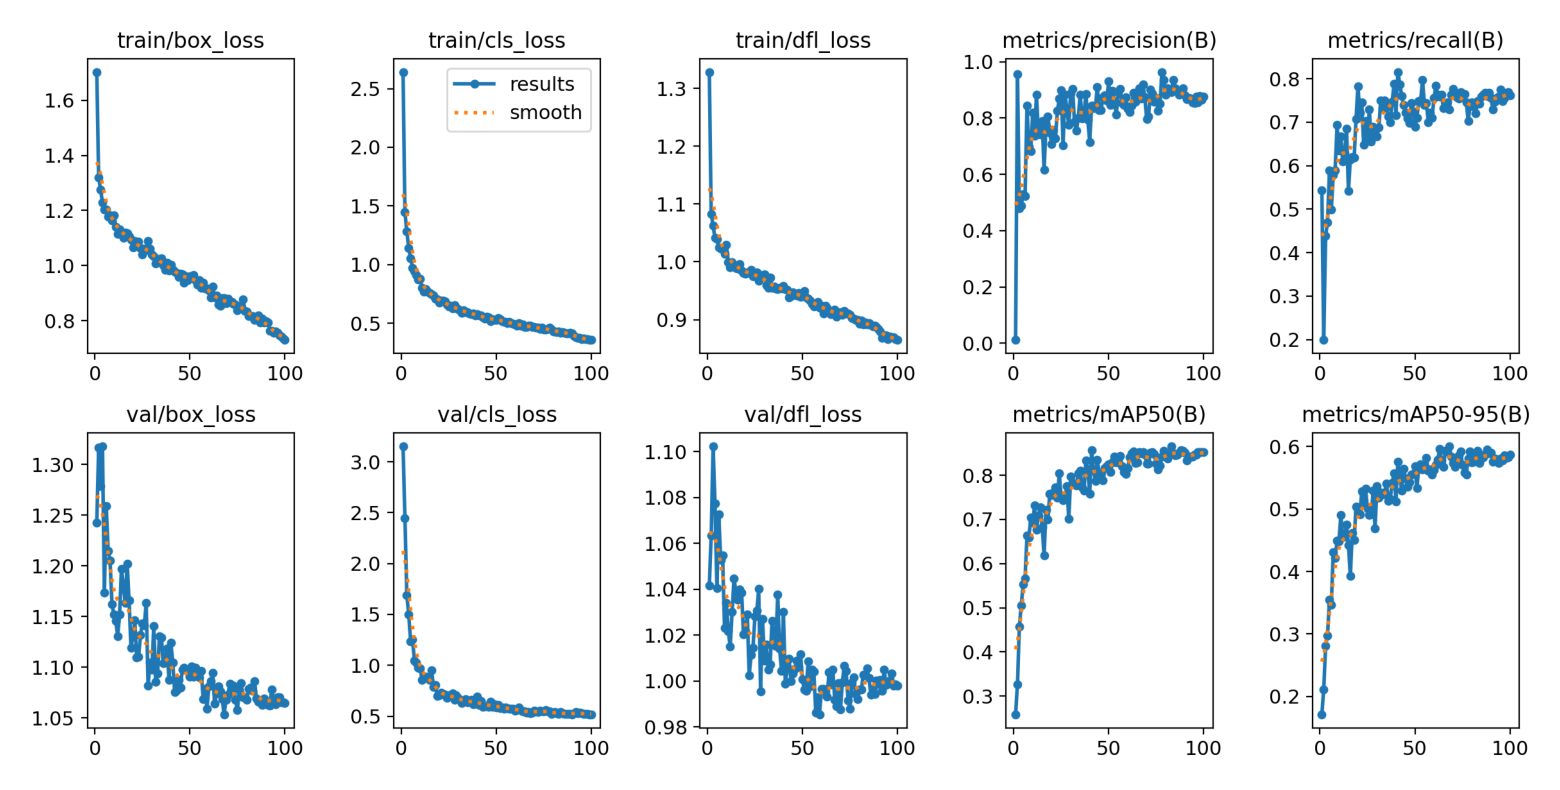

In [48]:
confusion_matrix = Image.open("runs/detect/train3/results.png") # Don't forget to look at folder train as well.
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()


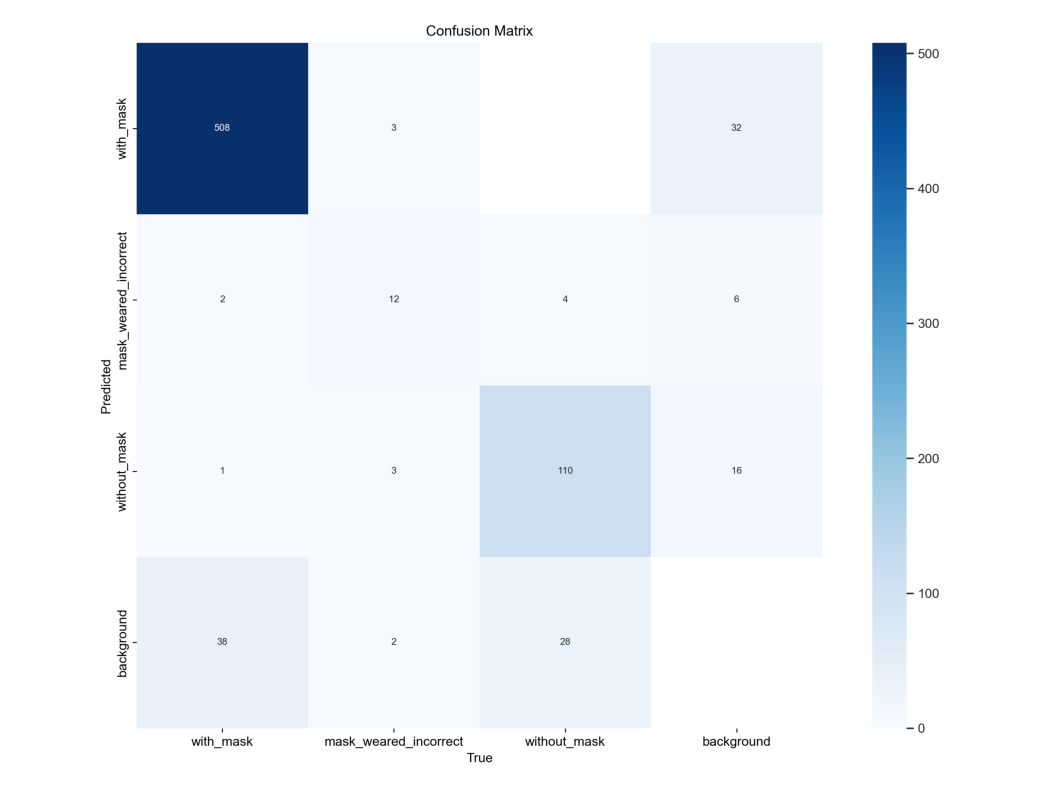

In [51]:
confusion_matrix = Image.open("runs/detect/train3/confusion_matrix.png") # ตรง /kaggle/working/runs/detect/train อย่าลืมดูดีๆนะบางทีกด train 2 รอบ โมเดลปัจจุบันเราจะไปอยู่ folder train2 นะ
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

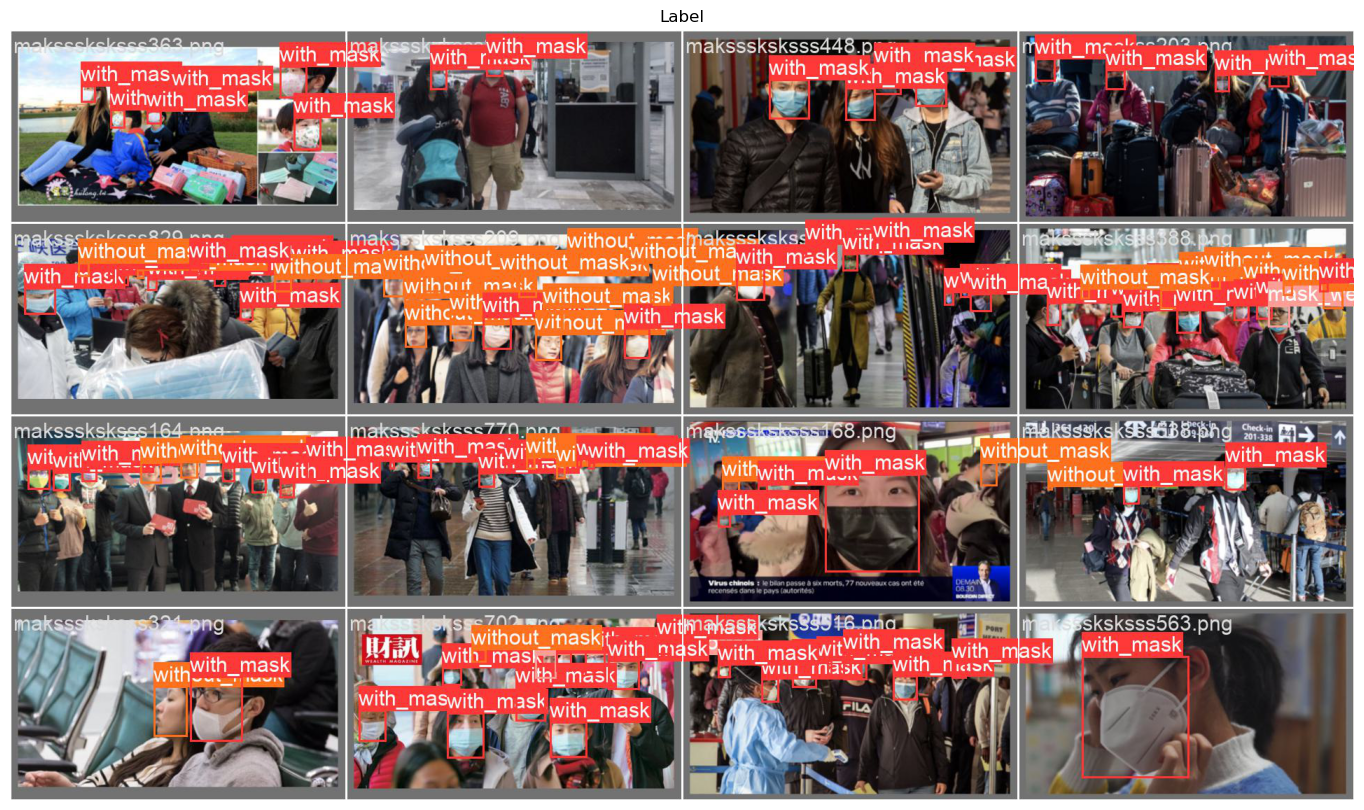

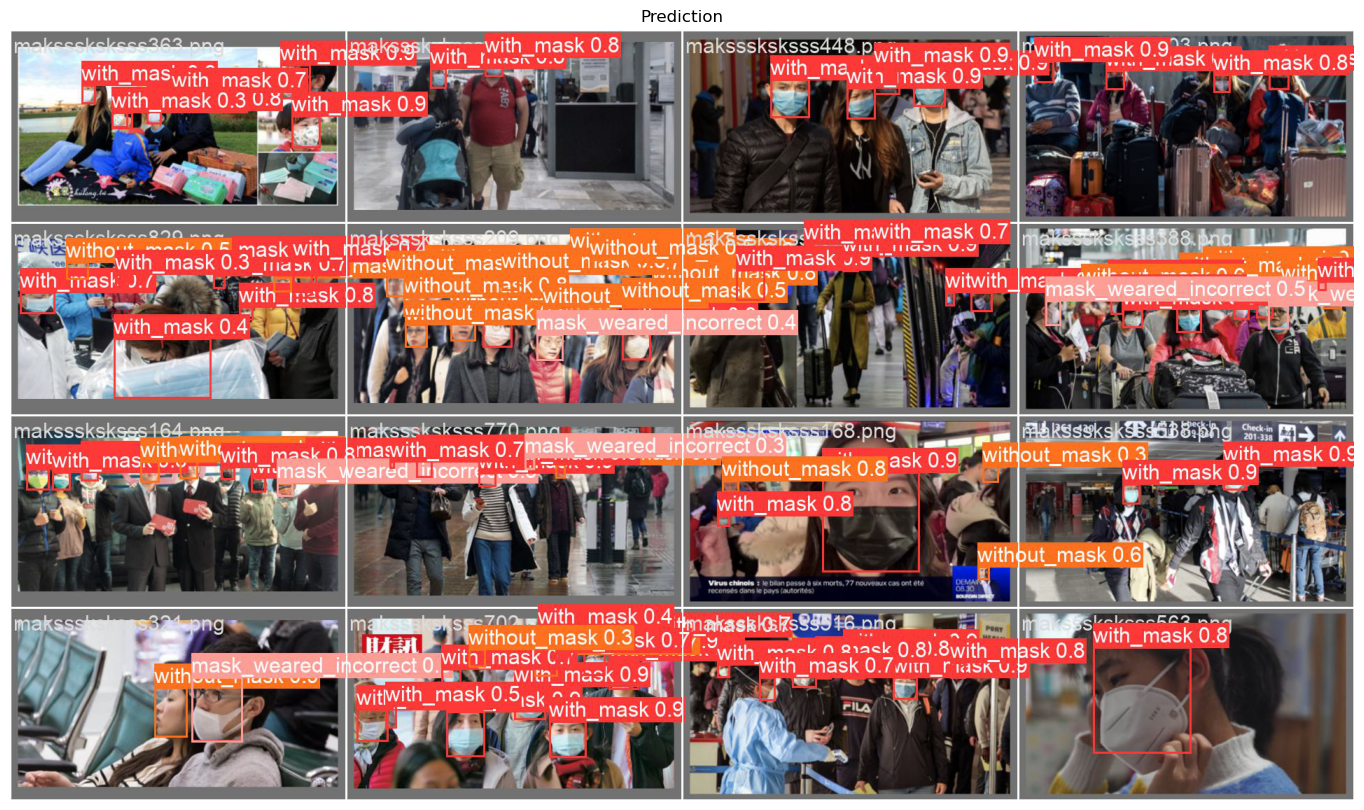

In [54]:
val_label = Image.open("runs/detect/train3/val_batch0_labels.jpg") # อย่าลืมดู folder train ด้วย
val_pred = Image.open("runs/detect/train3/val_batch0_pred.jpg") # อย่าลืมดู folder train ด้วย

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

In [55]:
model = YOLO(model="runs/detect/train3/weights/best.pt") # Don't forget to look at folder train as well the path of best.pt model.

In [56]:
filenames = glob.glob(test_path+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2], save=True, line_thickness=1)

WARNING  'line_thickness' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'line_width' instead.

0: 640x640 5 with_masks, 2 without_masks, 99.3ms
1: 640x640 1 without_mask, 99.3ms
Speed: 3.5ms preprocess, 99.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


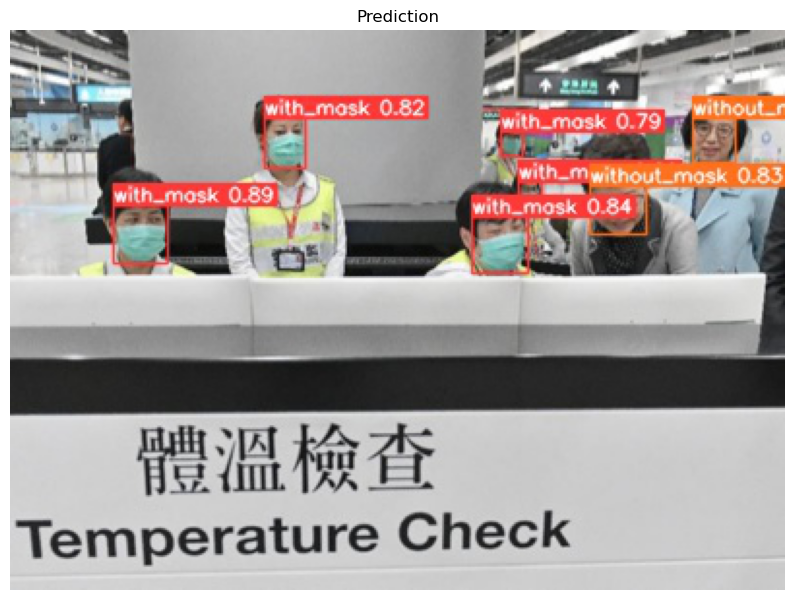

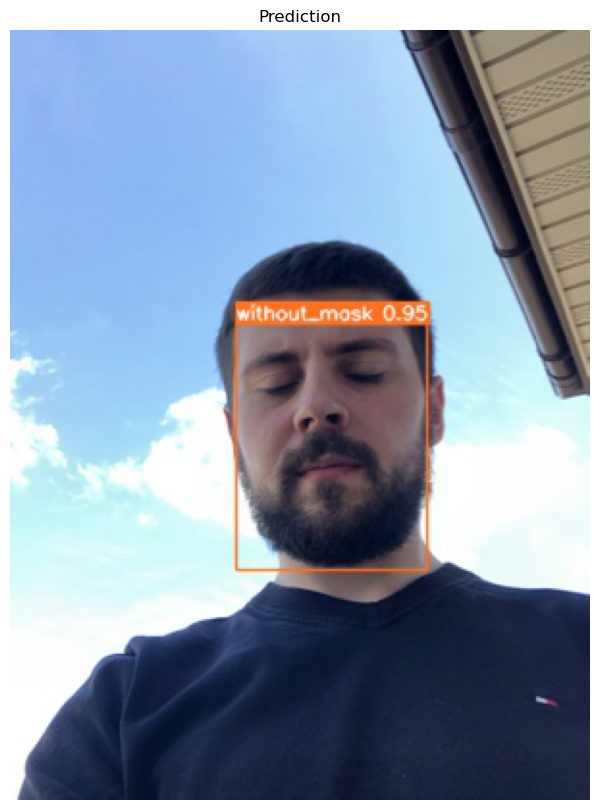

In [57]:
predicted_image = Image.open("runs/detect/predict/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/predict/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

In [68]:
vid = cv2.VideoCapture(0)

while True:
    success, frame = vid.read()

    if not success:
        break

    results = model.predict(frame, verbose=False, conf=0.5)
    annotated_frame = results[0].plot()

    # Add text to the annotated frame
    cv2.putText(annotated_frame, 'Press q to quit', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cv2.imshow('yolo', annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()


In [67]:

# define a video capture object
vid = cv2.VideoCapture('istockphoto-1217776095-640_adpp_is.mp4')
#vid = cv2.VideoCapture(0)

while True:

    # Capture the video frame by frame
    success, frame = vid.read()
    
    # Break if we reach end of video
    if not success:
        break

    # resize the frame (optional)
    frame = cv2.resize(frame, (0, 0), fx=2, fy=2)

    # Run YOLOv8 inference on the frame
    results = model.predict(frame, verbose=False, conf=0.5)

    # Visualize the results on the frame
    annotated_frame = results[0].plot()
    
    # Display a "Press q to quit" message
    cv2.putText(annotated_frame, 'Press q to quit', (20, 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 255), 2)

    # Display the resulting frame
    cv2.imshow('yolo', annotated_frame)

    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()

# Destroy all the windows
cv2.destroyAllWindows()